## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

Using TensorFlow backend.


## Configurations

In [2]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
import coco
config = coco.CocoConfig()
#COCO_DIR = "/home/pchaudha/mask-rcnn/Mask_RCNN-master/dataset-coco"  # TODO: enter value here
COCO_DIR = "/scratch/pchaudha/mask-rcnn/Mask_RCNN-master/dataset-coco"

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    7
NUM_LEVELS                     11
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE       

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Build validation dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset = coco.CocoDataset()
    dataset.load_coco(COCO_DIR, "test", year=2017)

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}\nLevels:{}".format(len(dataset.image_ids), dataset.class_names, dataset.level_names))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Images: 84
Classes: ['BG', 'person', 'bicycle', 'car', 'bus', 'flood', 'house']
Levels:['level0', 'level1', 'level2', 'level3', 'level4', 'level5', 'level6', 'level7', 'level8', 'level9', 'level10']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
if config.NAME == "shapes":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
weights_path = model.find_last()[1]

# Load weights

#weights_path = "/home/pchaudha/mask-rcnn/Mask_RCNN-master/logs/coco20180723T1007/mask_rcnn_coco_0160.h5"
#weights_path = "/scratch/pchaudha/mask-rcnn/Mask_RCNN-master/logs/coco20180723T1007/mask_rcnn_coco_0160.h5"
#weights_path = "/scratch/pchaudha/mask-rcnn/Mask_RCNN-master/logs/cluster/fold2/mask_rcnn_coco_0160.h5"
weights_path = "/scratch/pchaudha/ranking_loss/mask_exp/exp_1/logs/fold1/mask_rcnn_coco_0160.h5"
model.load_weights(weights_path, by_name=True)
print("Loading weights ", weights_path)
print("model loaded")

Loading weights  /scratch/pchaudha/ranking_loss/mask_exp/exp_1/logs/fold1/mask_rcnn_coco_0160.h5
model loaded


## Run Detection

In [8]:
image_id = random.choice(dataset.image_ids)
print(image_id)

35


In [9]:
image_id = random.choice(dataset.image_ids)
#image_id = 1
image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_level_id =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print(gt_class_id)
print(gt_level_id)
for i, id in enumerate(gt_class_id):
    print(dataset.class_names[int(id)], end=" ")

image ID: coco.600046 (66) http://cocodataset.org/#explore?id=600046
[3 3 3 3 3 5 6 1 1]
[2 0 0 0 0 0 0 0 0]
car car car car car flood house person person 

In [11]:
import skimage

#name = str(info["id"])
# Load image
#name = "Flood_7007.jpg"
#path = "/home/pchaudha/Images/After cleaning/dataset/FloodImages_newname/"
#path = "/home/pchaudha/resnet50/Original/"

name = "picture1.jpg"
path = "/scratch2/Downloads/"
#path = "/home/pchaudha/Pictures/"
#path = "/home/pchaudha/Pictures/new_flood_imgs/"
#path = "/scratch2/Images/After cleaning/15_nov_2019/"

t_path = path+name
image = skimage.io.imread(t_path)
print(image.shape)
#if(image.shape[2]!=3):
#                image = image[:,:,:3]
# If grayscale. Convert to RGB for consistency.
#if image.ndim != 3:
#    image = skimage.color.gray2rgb(image)

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
print(r['class_ids'])
print(r['scores'])
print(r['level_ids'])
print(r['level_scores'])
visualize.display_instances(name,image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['level_ids'], dataset.level_names, r['level_scores'], r['scores'], ax=ax,
                            title="Predictions")
#log("gt_class_id", gt_class_id)
#log("gt_bbox", gt_bbox)
#log("gt_mask", gt_mask)
#print(dataset.level_names[int(0)])



(712, 984, 3)
Processing 1 images
image                    shape: (712, 984, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.59152
image_metas              shape: (1, 26)               min:    0.00000  max: 1024.00000
[3 5 3 3 3 3 3 3 3 4 3 3]
[0.9995871  0.9988913  0.99839956 0.9950265  0.99424225 0.95689964
 0.95651644 0.95336086 0.9410259  0.85791814 0.80776906 0.79061306]
[0 0 2 0 2 0 0 0 2 0 0 0]
[0.35500494 0.99998    0.5990349  0.79058844 0.46951744 0.99965143
 0.99980253 0.9975745  0.8253742  0.99964356 0.99998534 0.9999684 ]


In [25]:
#temp
#print(results[0])
x = results[0]
print(x['rois'])

#for case when no detection or length of bbox is zero
print(type(x['rois']))
#s = x['rois'].size
#print(size)
if (x['rois'].size ==0):
    print("Empty")
    x['rois'] = np.append(x['rois'],0)
    print(x['rois'])

#print(len(x['rois']))
print(gt_bbox)
#print(range(len(gt_bbox)))
x,y,w,h = gt_bbox[0]
print(x)
from math import hypot

[]
<class 'numpy.ndarray'>
Empty
[0]
[[226 148 798 903]
 [518   8 797 960]]
226


In [18]:
#remove later
def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.

    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]

In [35]:
#remove later
iou_threshold=0.5

gt_boxes = gt_bbox
gt_class_ids = gt_class_id
pred_boxes = r['rois']
pred_class_ids = r['class_ids']
pred_scores = r['scores']
gt_level_ids = gt_level_id
pred_level_ids = r['level_ids']
pred_level_scores = r['level_scores']


#import math hypotenuse lib
from math import hypot

gt_boxes = trim_zeros(gt_boxes)
pred_boxes = trim_zeros(pred_boxes)
pred_scores = pred_scores[:pred_boxes.shape[0]]
indices = np.argsort(pred_scores)[::-1]
pred_boxes = pred_boxes[indices]
pred_class_ids = pred_class_ids[indices]
pred_scores = pred_scores[indices]

# Compute IoU overlaps [pred_boxes, gt_boxes]
overlaps = utils.compute_overlaps(pred_boxes, gt_boxes)

# Loop through ground truth boxes and find matching predictions
match_count = 0
match_level_count = 0
pred_match = (-1)*np.ones([pred_boxes.shape[0]])
gt_match = (-1)*np.ones([gt_boxes.shape[0]])
pred_level_match = (-1)*np.ones([pred_boxes.shape[0]])
gt_level_match = (-1)*np.ones([gt_boxes.shape[0]])
for i in range(len(pred_boxes)):
    # Find best matching ground truth box
    sorted_ixs = np.argsort(overlaps[i])[::-1]
    for j in sorted_ixs:
        # If ground truth box is already matched, go to next one
        if gt_match[j] == 1:
            continue
        # If we reach IoU smaller than the threshold, end the loop
        iou = overlaps[i, j]
        if iou < iou_threshold:
            break
        # Do we have a match?
        if pred_class_ids[i] == gt_class_ids[j]:
            if(pred_level_ids[i]==gt_level_ids[j]):
                match_level_count += 1
                gt_level_match[j] = 1
                pred_level_match[i] = 1
            else:
                match_level_count += 0
                gt_level_match[j] = 0
                pred_level_match[i] = 0

            match_count += 1
            gt_match[j] = i
            pred_match[i] = j
            break
print(gt_match)
print(pred_match)
#remove -1 entries from gt_level_match and pred_level_match
index1, = np.where(gt_match==-1)
index2, = np.where(pred_match==-1)
print(index2)

#to remove the flood class
#from bboxes. so that is not
#the nearest neighbour we find
#in case of false positive
duplicate_gtbbox = gt_boxes
print(duplicate_gtbbox)
for i in range(len(gt_class_ids)):
    if gt_class_ids[i]==5:
        duplicate_gtbbox = np.delete(duplicate_gtbbox,i,0)
        break
print(duplicate_gtbbox)

#For the indexes with no match, FP and FN
#We will find nearest gt level for FP.
if index2.size != 0:
    for idx in range(len(index2)):
        fp_index = index2[idx]
        x, y, w, h = pred_boxes[fp_index]
        centre_x = x+(w/2)
        centre_y = y+(h/2)
        min_dis = 99999
        closest_bbox = -1
        for bbox in range(len(duplicate_gtbbox)):
            x_temp, y_temp, w_temp, h_temp = duplicate_gtbbox[bbox]
            centre_temp_x = x_temp +(w_temp/2)
            centre_temp_y = y_temp + (h_temp / 2)
            dis = hypot(centre_x - centre_temp_x, centre_y-centre_temp_y)
            if dis < min_dis:
                min_dis = dis
                closest_bbox = bbox
            else:
                pass
        #get the level value of closest bbox
        level = gt_level_ids[closest_bbox]
        #update the gt_value of FP
        #gt_level_ids = np.insert(gt_level_ids, index2[idx], level)
        
        #check if index is greater than elements 
        #else 
        while(len(pred_level_ids)> len(gt_level_ids)):
            gt_level_ids = np.append(gt_level_ids, 0)
        
        t = index2[idx]
        gt_level_ids[t]= level       
            



print(gt_level_ids)
print(pred_level_ids)

#trim mean
import scipy.stats
gt_level = scipy.stats.trim_mean(gt_level_ids,0.2)
pred_level = scipy.stats.trim_mean(pred_level_ids,0.2)
print(gt_level)
print(pred_level)

[ 7.  1.  5.  0. -1.  4.  2. -1.  8.]
[ 3.  1.  6. -1.  5.  2. -1.  0.  8. -1.]
[3 6 9]
[[ 225    3  797 1003]
 [ 293  379  498  556]
 [ 284  507  490  632]
 [ 316  657  618  849]
 [ 284  203  636  954]
 [ 293  152  595  274]
 [ 263  476  390  560]
 [ 303  781  501  898]
 [ 289  267  344  297]]
[[293 379 498 556]
 [284 507 490 632]
 [316 657 618 849]
 [284 203 636 954]
 [293 152 595 274]
 [263 476 390 560]
 [303 781 501 898]
 [289 267 344 297]]
[0 0 0 0 4 4 0 0 0 4]
[4 0 0 0 4 0 4 0 0 0]
0.6666666666666666
0.6666666666666666


/usr/lib/python3/dist-packages/scipy/stats/stats.py:2867: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)


In [14]:
tf.VERSION

'1.11.0'

### Confusion Matrix

In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(gt_level_id, r['level_ids'])

array([[0, 0, 1],
       [1, 0, 0],
       [0, 0, 0]])

### Precision-Recall

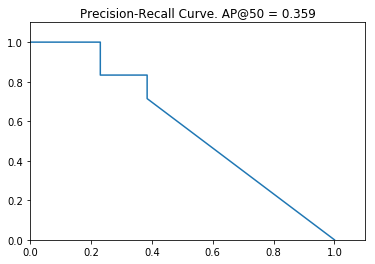

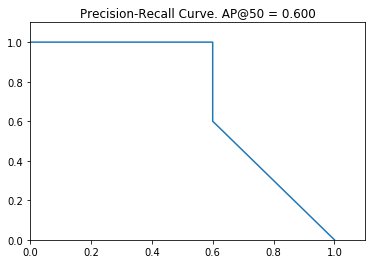

In [19]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, 
                                          r['rois'], r['class_ids'], r['scores'])

#level precision recall curve
AP2, precisions2, recalls2, overlaps2 = utils.compute_ap(gt_bbox, gt_level_id, r['rois'], r['level_ids'], r['level_scores'])

AP4, precisions4, recalls4,overlaps4 = utils.compute_ap_level(gt_bbox, gt_class_id,
               r['rois'], r['class_ids'], r['scores'],
                gt_level_id, r['level_ids'], r['level_scores'])

visualize.plot_precision_recall(AP, precisions, recalls)

visualize.plot_precision_recall(AP2, precisions2, recalls2)

visualize.plot_precision_recall(AP4, precisions4, recalls4)

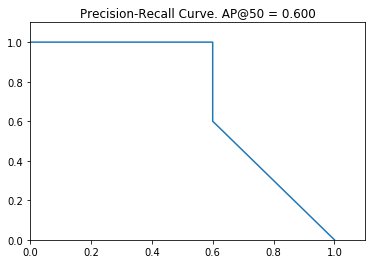

In [20]:
AP3, precisions3, recalls3, overlaps3 = utils.compute_ap_condensed(gt_bbox, gt_class_id,
               r['rois'], r['class_ids'], r['scores'],
                gt_level_id, r['level_ids'], r['level_scores'])
visualize.plot_precision_recall(AP3, precisions3, recalls3)

In [56]:
# Grid of ground truth objects and their predictions
#visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
#                        overlaps, dataset.class_names)

In [21]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps_l(gt_class_id,gt_level_id, r['class_ids'] ,r['level_ids'], r['level_scores'],
                        overlaps, dataset.level_names, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [14]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_level_id =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id,
                              r['rois'], r['class_ids'], r['scores'])
        APs.append(AP)
    return APs

# Pick a set of random images
#image_ids = np.random.choice(dataset.image_ids, 10)
image_ids = dataset.image_ids
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))


/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


mAP @ IoU=50:  0.8092143387388007


In [8]:
#level table for interpolation

level_ref = np.array([[0.0,0.0],
         [0.0,1.0],
         [1.0,10.0],
         [10.0, 21.25],
         [21.25,42.5],
         [42.5,63.75],
         [63.75,85.0],
         [85.0,106.25],
         [106.25,127.25],
         [127.25,148.75],
         [148.75,170.0]])

In [9]:
#new formula check
import math
#level to cm conversion
def level_to_cm(level_ref,level):
    floor = int(math.floor(level))
    print(floor)
    ceil = int(math.ceil(level))
    print(ceil)
    percent = level - floor
        
    level_cm = (level_ref[ceil][1]- level_ref[ceil][0])*percent + level_ref[floor][1]
    return level_cm

lev = 3.7
x = level_to_cm(level_ref,lev)
print(x)

3
4
36.125


In [26]:
#don't use this one. use the above one
import math
#level to cm conversion
def level_to_cm(level_ref,level):
    floor = int(math.floor(level))
    print(floor)
    ceil = int(math.ceil(level))
    print(ceil)
    percent = level - floor
    print(percent)
    if percent == 0:
        level = int(level)
        level_cm = level_ref[level][1]
        print("level_cm is %f", level_cm)
        return level_cm
        
    if floor >=1:
        print("in floor >=1")
        level_cm = (level_ref[ceil][1]- level_ref[floor][0])*percent + level_ref[floor-1][1]
    if floor <1:
        level_cm = (level_ref[ceil][1]- level_ref[floor][0])*percent
    print(level_cm)
    return level_cm

lev = 4.1
x = level_to_cm(level_ref,lev)

4
5
0.09999999999999964
in floor >=1
25.499999999999986


In [11]:
##remove

##########################################################
#for calculation of new trimmed mean for each image
#exp 3
#with finding the nearest neighbour and taking its level
#in case of FPlevel_cm = (level_ref[ceil][1]- level_ref[floor][0])*percent
###########################################################

def compute_accuracy_exp3(image_ids):
    labels = []
    preds = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_level_id =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        gt_level, pred_level = utils.compute_trim_mean_exp3(gt_bbox, gt_class_id,
               r['rois'], r['class_ids'], r['scores'],
                gt_level_id, r['level_ids'], r['level_scores'])
        print(gt_level)
        print(pred_level)
        gt_level = level_to_cm(level_ref, gt_level)
        pred_level = level_to_cm(level_ref, pred_level)
        print(gt_level)
        print(pred_level)
        labels.append(gt_level)
        preds.append(pred_level)
    return labels, preds

image_nr = [3]
labels, preds = compute_accuracy_exp3(image_nr)

n = len(labels)
labels = np.array(labels)
print(labels)
print(preds)
preds = np.array(preds)
diff = labels - preds
print(abs(diff))

/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


[[ 485  349  642  689]
 [ 321  909  401 1022]
 [ 364  219  417  247]
 [ 398    1  850 1021]
 [ 175    3  411 1021]
 [ 330  412  633  610]
 [ 335  162  412  270]]
[3 3 3 0 3 0 3]
[0 4 4 3 1 0 2]
2.4
2.0
2.4
2.0
2
3
0.3999999999999999
9.099999999999998
2
2
0.0
1.0
9.099999999999998
1.0
[9.1]
[1.0]
[8.1]


/usr/lib/python3/dist-packages/scipy/stats/stats.py:2867: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)


In [13]:
##########################################################
#for calculation of new trimmed mean for each image
#exp 3
#with finding the nearest neighbour and taking its level
#in case of FP
###########################################################

def compute_accuracy_exp3(image_ids):
    labels = []
    preds = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_level_id =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        
        #to check if no detections
        #or bbox length is zero
        if (r['rois'].size ==0):
            #r['rois'] = np.append(r['rois'],0)
            pred_level = 0
            import scipy.stats
            gt_level = scipy.stats.trim_mean(gt_level_id,0.2)
            gt_level = level_to_cm(level_ref, gt_level)

        else:
            gt_level, pred_level = utils.compute_trim_mean_exp3(gt_bbox, gt_class_id,
               r['rois'], r['class_ids'], r['scores'],
                gt_level_id, r['level_ids'], r['level_scores'])
            #print(gt_level)
            #print(pred_level)
            gt_level = level_to_cm(level_ref, gt_level)
            pred_level = level_to_cm(level_ref, pred_level)
            print(gt_level)
            print(pred_level)
        labels.append(gt_level)
        preds.append(pred_level)
    return labels, preds

labels, preds = compute_accuracy_exp3(dataset.image_ids)

n = len(labels)
labels = np.array(labels)
print(labels)
print(preds)
preds = np.array(preds)
diff = labels - preds
diff2 = np.array(diff)
diff2 = abs(diff2)
print(diff2)
print(np.mean(diff2))
#diff = preds - labels
#print(diff)
#square = np.square(diff)
#print(square)
#total = 0
#mse1 = np.mean(square)
#print(mse1)
#for item in square:
#    total = total + item
#mse = total/n
#rmse = np.sqrt(mse)
#print(mse)
#print(rmse)



/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


[[ 480   35  794 1021]
 [ 227    5  800 1018]
 [ 411  241  573  329]]
[0 5 0 5]
[0 3 3 3]
2.5
2.25
2
3
2
3
15.625
12.8125


/usr/lib/python3/dist-packages/scipy/stats/stats.py:2867: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)


[[ 566  344  643  487]
 [ 270  137  732  751]
 [ 334  566  460  741]
 [ 366    7  754 1020]
 [ 287  236  635  524]
 [ 337  840  381  862]]
[0 4 3 0 0 3]
[3 0 0 5]
1.5
2.0
1
2
2
2
5.5
10.0
[[ 216    1  775 1021]
 [ 530    3  826 1021]
 [ 304  432  528  673]]
[5 0 5 0]
[0 6 5 0]
2.5
2.75
2
3
2
3
15.625
18.4375
[[ 485  349  642  689]
 [ 321  909  401 1022]
 [ 364  219  417  247]
 [ 398    1  850 1021]
 [ 175    3  411 1021]
 [ 330  412  633  610]
 [ 335  162  412  270]]
[3 3 3 0 3 0 3]
[0 4 4 3 1 0 2]
2.4
2.0
2
3
2
2
14.5
10.0
[[ 225    3  797 1003]
 [ 293  379  498  556]
 [ 284  507  490  632]
 [ 316  657  618  849]
 [ 284  203  636  954]
 [ 293  152  595  274]
 [ 263  476  390  560]
 [ 303  781  501  898]
 [ 289  267  344  297]]
[0 0 0 4 4 4 0 0 0]
[4 4 0 3 0 0 0 0]
1.1428571428571428
1.1666666666666667
1
2
1
2
2.285714285714285
2.500000000000001
[[ 457    5  794 1014]
 [ 399  303  736  451]]
[0 3]
[0 4]
1.5
2.0
1
2
2
2
5.5
10.0


/usr/lib/python3/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


[[ 505  420  592  479]
 [ 511  774  580  844]
 [ 485  951  572 1013]
 [ 494  402  538  448]
 [ 594    1  797 1021]
 [ 225    3  514  369]
 [ 238  439  497  774]
 [ 297  161  737  355]
 [ 289  448  755  633]
 [ 319  622  755  818]]
[1 0 0 0 0 0 0 0 3 3]
[0 3 3 3 3 0 0 0]
0.16666666666666666
1.5
0
1
1
2
0.16666666666666666
5.5
[[ 471  709  533  731]
 [ 299  265  607  616]
 [ 362   98  379  149]
 [ 364    0  378   28]
 [ 511    3  825 1023]
 [ 199    0  365  170]
 [ 429  874  503  902]
 [ 437  703  517  737]]
[2 4 2 2 0 0 0 2]
[0 2 5 4 6 0 0]
1.3333333333333333
2.2
1
2
2
3
3.999999999999999
12.250000000000002
[[ 306  243  556  533]
 [ 482   28  493   44]
 [ 487    3  797 1019]]
[3 0 0]
[0 3]
1.0
1.5
1
1
1
2
1.0
5.5
[[ 497    2  879 1020]
 [ 145    7  497 1022]
 [ 406  367  670  539]]
[0 0 0]
[0 6 0]
0.0
2.0
0
0
2
2
0.0
10.0
[[ 460  400  559  875]
 [ 238    1  797 1021]]
[6 0]
[0 6]
3.0
3.0
3
3
3
3
21.25
21.25
[[ 374   72  725  631]
 [ 316  717  498  914]
 [ 336  399  489  627]
 [ 414    4

[[ 469  302  685  803]
 [ 337    3  795 1019]
 [ 265  693  331  882]
 [ 270  962  336 1023]
 [ 361  437  531  501]
 [ 472  445  584  546]
 [ 477  360  587  458]
 [ 384  406  462  446]]
[2 0 0 0 0 0 0 0]
[0 0 3 0]
0.0
0.75
0
0
0
1
0.0
0.75
[[ 239  380  744  876]
 [ 507  213  553  279]
 [ 505  340  538  384]
 [ 501  310  534  349]
 [ 526    3  795 1020]
 [ 317  835  441  986]]
[3 3 2 3 0 0]
[0 3 2 0 0]
2.0
0.6666666666666666
2
2
0
1
10.0
0.6666666666666666
[[ 381  498  425  619]
 [ 428    9  791 1018]
 [ 224  540  424 1020]
 [ 253  216  426  504]
 [ 288  210  447  291]
 [ 281  275  452  377]]
[0 0 0 2 2 2]
[0 0 3 0 0]
1.0
0.0
1
1
0
0
1.0
0.0
[[ 387  236  500  520]
 [ 451    3  797 1010]
 [ 511  111  657  198]
 [ 532  162  692  312]
 [ 526  243  673  327]
 [ 513  290  667  402]
 [ 360  520  459  586]
 [ 376  523  488  552]]
[8 0 0 0 0 0 0 0]
[0 0 0 0 0 5]
0.0
0.0
0
0
0
0
0.0
0.0
[[ 296  235  701  526]
 [ 265  515  711  826]
 [ 229    6  792 1019]]
[4 4 0]
[4 0 5]
2.6666666666666665
3.0
2


In [14]:
#exp2
import scipy.stats
def compute_accuracy_exp2(image_ids):
    labels = []
    preds = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_level_id =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        
        #to check if no detections
        #or bbox length/class/level_ids is zero
        if (r['level_ids'].size ==0):
            r['level_ids'] = np.append(r['level_ids'],0)
        
        pred_level_id = r['level_ids']
        #trim mean
        gt_level = scipy.stats.trim_mean(gt_level_id,0.2)
        pred_level = scipy.stats.trim_mean(pred_level_id,0.2)
        gt_level = level_to_cm(level_ref, gt_level)
        pred_level = level_to_cm(level_ref, pred_level)
        print(gt_level)
        print(pred_level)
        labels.append(gt_level)
        preds.append(pred_level)
    return labels, preds

labels, preds = compute_accuracy_exp2(dataset.image_ids)

n = len(labels)
labels = np.array(labels)
print(labels)
print(preds)
preds = np.array(preds)
diff = preds - labels
#print(diff)
diff2 = np.array(diff)
diff2 = abs(diff2)
print(diff2)
print(np.mean(diff2))


/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
/usr/lib/python3/dist-packages/scipy/stats/stats.py:2867: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)


3
4
2
3
28.333333333333336
12.8125
1
2
2
2
5.5
10.0
1
2
2
3
7.000000000000001
18.4375
2
3
2
2
14.5
10.0
1
2
1
2
2.285714285714285
2.500000000000001
1
2
2
2
5.5
10.0


/usr/lib/python3/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


0
1
1
2
0.6666666666666666
5.5
0
1
2
3
0.6666666666666666
12.250000000000002
1
1
1
2
1.0
5.5
2
2
2
2
10.0
10.0
3
3
3
3
21.25
21.25
0
1
0
1
0.8
0.6
3
4
1
2
25.500000000000004
7.75
0
1
2
2
0.6666666666666666
10.0
3
4
2
3
28.333333333333336
13.750000000000002
4
4
5
6
42.5
70.83333333333333
3
3
2
3
21.25
13.750000000000002
6
6
3
3
85.0
21.25
0
0
0
0
0.0
0.0
1
1
3
3
1.0
21.25
1
2
2
2
5.5
10.0
0
0
0
0
0.0
0.0
2
3
2
2
15.625
10.0
0
1
0
1
0.6666666666666666
0.6666666666666666
4
4
3
4
42.5
28.333333333333336
2
2
2
3
10.0
14.5
6
7
6
6
93.5
85.0
1
2
0
1
5.5
0.7142857142857143
2
3
2
2
17.5
10.0
3
4
2
2
28.333333333333336
10.0
4
4
2
3
42.5
11.874999999999998
3
4
3
4
28.333333333333336
31.875
2
2
2
3
10.0
17.5
2
3
2
3
19.642857142857146
16.42857142857143
0
1
1
2
0.75
3.25
2
3
4
5
13.750000000000002
47.8125
0
1
0
1
0.75
0.75
1
1
1
2
1.0
8.2
3
3
3
3
21.25
21.25
1
2
2
2
5.5
10.0
2
3
2
2
15.625
10.0
0
0
1
1
0.0
1.0
0
0
0
1
0.0
0.75
2
2
2
2
10.0
10.0
0
1
0
0
0.75
0.0
1
2
1
2
3.999999999999999
3.999999999

In [15]:
#exp1

def compute_accuracy_exp1(image_ids):
    labels = []
    preds = []
    for image_id in image_ids:
        # Load image
        print("image_id is %d." % (image_id))
        image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_level_id =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        print(r['rois'])
        
        #to check if no detections
        #or bbox length is zero
        if (r['rois'].size ==0):
            #r['rois'] = np.append(r['rois'],0)
            pred_level = 0
            import scipy.stats
            gt_level = scipy.stats.trim_mean(gt_level_id,0.2)
            gt_level = level_to_cm(level_ref, gt_level)
            
        else:
            print("should not print")
            gt_level, pred_level = utils.compute_trim_mean_level(gt_bbox, gt_class_id,
               r['rois'], r['class_ids'], r['scores'],
                gt_level_id, r['level_ids'], r['level_scores'])
            print(gt_level)
            print(pred_level)
            gt_level = level_to_cm(level_ref, gt_level)
            pred_level = level_to_cm(level_ref, pred_level)
            print(gt_level)
            print(pred_level)
        labels.append(gt_level)
        preds.append(pred_level)
    return labels, preds

labels, preds = compute_accuracy_exp1(dataset.image_ids)
#labels, preds = compute_accuracy_exp1([64])

n = len(labels)
labels = np.array(labels)
print(labels)
print(preds)
preds = np.array(preds)
diff = preds - labels
diff2 = np.array(diff)
diff2 = abs(diff2)
print(diff2)
print(np.mean(diff2))

image_id is 0.


/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


[[ 492   20  789 1013]
 [ 407  244  560  330]
 [ 248  208  553  960]
 [ 265   30  666  215]]
should not print
iou is: %d 0.9248771727605323
iou is: %d 0.8587022849006712
iou is: %d 0.3951423811566563
iou is: %d 0.12780623276119005
[0 5]
[0 3]
2.5
1.5
2
3
1
2
15.625
5.5
image_id is 1.


/usr/lib/python3/dist-packages/scipy/stats/stats.py:2867: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)


[[ 333  570  461  737]
 [ 292  227  634  501]
 [ 339    1  751 1012]
 [ 369  145  696  681]]
should not print
iou is: %d 0.9400464617583989
iou is: %d 0.8773305453911832
iou is: %d 0.9154716302575884
iou is: %d 0.6178772367697449
[4 3 0 0]
[3 0 0 5]
1.75
2.0
1
2
2
2
7.75
10.0
image_id is 2.
[[ 417   14  831  942]
 [ 275  429  514  654]
 [ 208   23  565  810]
 [ 271  468  569 1003]]
should not print
iou is: %d 0.6686139346496864
iou is: %d 0.7625247387101523
iou is: %d 0.47645175167743326
iou is: %d 0.2796134554000491
[0 0]
[0 6]
0.0
3.0
0
0
3
3
0.0
21.25
image_id is 3.
[[ 402    0  844 1024]
 [ 328  407  628  609]
 [ 485  360  643  688]
 [ 322  911  407 1022]
 [ 336  240  415  272]
 [ 185    6  417  934]
 [ 348  220  416  245]]
should not print
iou is: %d 0.9741404642962093
iou is: %d 0.9485845398138573
iou is: %d 0.9588143293364118
iou is: %d 0.9034617762208943
iou is: %d 0.2662307333021952
iou is: %d 0.8531910046538874
iou is: %d 0.6900212314225053
[3 3 3 0 3 0]
[0 4 4 3 0 2]
2.25
2.

/usr/lib/python3/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


[[ 561   30  786 1024]
 [ 312  622  754  823]
 [ 290  164  730  354]
 [ 285  452  744  631]
 [ 504  421  597  489]
 [ 509  770  590  849]
 [ 495  397  557  451]
 [ 226   13  577  216]]
should not print
iou is: %d 0.7913557757093305
iou is: %d 0.9575686785417462
iou is: %d 0.9490137270734802
iou is: %d 0.9369463681752295
iou is: %d 0.7870846981750117
iou is: %d 0.7548054383497421
iou is: %d 0.5827931644077784
iou is: %d 0.4931049315553756
[1 0 0 0 3 3 3]
[0 3 3 3 3 0 0]
1.4
1.8
1
2
1
2
4.6
8.2
image_id is 7.
[[ 481    0  818 1002]
 [ 430  703  525  739]
 [ 488  636  537  654]
 [ 508  768  578  792]
 [ 277  270  612  624]
 [ 481  930  528  945]
 [ 480  836  528  853]]
should not print
iou is: %d 0.8731199877014527
iou is: %d 0.7953216374269005
iou is: %d 0.0
iou is: %d 0.0
iou is: %d 0.887105635561475
iou is: %d 0.0
iou is: %d 0.0
[4 0 2]
[0 2 6]
2.0
2.6666666666666665
2
2
2
3
10.0
17.5
image_id is 8.
[[ 469    0  788 1007]
 [ 311  244  563  546]]
should not print
iou is: %d 0.9048321950

[[ 352   14  763 1004]
 [ 339  309  411  340]
 [ 510  336  698  706]
 [ 339  699  395  721]
 [ 259   19  420  841]
 [ 415  410  634  545]
 [ 347  681  392  693]
 [ 352  625  388  643]]
should not print
iou is: %d 0.8741566650095874
iou is: %d 0.7861080485115767
iou is: %d 0.8347685683530678
iou is: %d 0.560064935064935
iou is: %d 0.7142004893253343
iou is: %d 0.6886277106439331
iou is: %d 0.6122448979591837
iou is: %d 0.0
[4 0 4 0 4 4 4]
[0 2 3 3 5 0 2]
3.2
2.0
3
4
2
2
25.500000000000004
10.0
image_id is 31.
[[196  23 841 995]
 [342 632 542 920]]
should not print
iou is: %d 0.9500731944608615
iou is: %d 0.9392012210633427
[0 5]
[0 7]
2.5
3.5
2
3
3
4
15.625
31.875
image_id is 32.
[[ 458   13  838 1020]
 [ 528  770  599  930]
 [ 554  897  621 1018]
 [ 513  666  557  838]
 [ 327  276  486  356]
 [ 469  528  547  693]
 [ 515  813  532  858]
 [ 417  525  461  538]]
should not print
iou is: %d 0.8794149359613854
iou is: %d 0.919229469415343
iou is: %d 0.037140370166758294
iou is: %d 0.797373

[[ 549    0  872 1019]
 [ 540  110  730  237]
 [ 482  794  731  909]
 [ 491  899  610  943]
 [ 491  312  665  381]]
should not print
iou is: %d 0.8846052562279454
iou is: %d 0.8976970433989512
iou is: %d 0.7766356270407546
iou is: %d 0.9026870007262164
iou is: %d 0.9023820644558618
[0 3 3 3 0]
[0 3 1 0 3]
2.0
1.3333333333333333
2
2
1
2
10.0
3.999999999999999
image_id is 55.
[[ 507   62  789 1003]
 [ 563  527  655  633]]
should not print
iou is: %d 0.6031941590442073
iou is: %d 0.9532746823069403
[0 8]
[0 8]
4.0
4.0
4
4
4
4
42.5
42.5
image_id is 56.
[[484   0 796 990]
 [503 260 730 384]
 [500 345 654 436]
 [513 648 734 781]
 [512 621 674 682]
 [544 477 657 554]
 [548 407 675 492]
 [553 532 678 636]
 [237 444 353 756]
 [247 109 421 835]]
should not print
iou is: %d 0.637811290802659
iou is: %d 0.7987686694789647
iou is: %d 0.7912087912087912
iou is: %d 0.8983945458544095
iou is: %d 0.735910572892408
iou is: %d 0.8221163012392755
iou is: %d 0.7702357943563973
iou is: %d 0.8251285301781816

[[442  21 786 986]
 [449 165 495 249]
 [446 258 494 343]
 [236 114 462 992]
 [383 334 497 665]]
should not print
iou is: %d 0.9058918939936788
iou is: %d 0.8936170212765957
iou is: %d 0.8342033827521403
iou is: %d 0.8059103213715555
iou is: %d 0.7495457298606905
[5 5 5 0 5]
[0 3 2 3 5]
5.0
2.6666666666666665
5
5
2
3
63.75
17.5
image_id is 80.
[[ 358   40  798 1001]
 [ 270  628  603  791]
 [ 430  670  648  781]
 [ 241  331  477 1014]]
should not print
iou is: %d 0.8981268153619967
iou is: %d 0.8752589308427517
iou is: %d 0.5409537978345318
iou is: %d 0.6813255558373489
[2 0 2 2]
[0 0 4 0]
1.5
1.0
1
2
1
1
5.5
1.0
image_id is 81.
[[ 470    0  790 1003]
 [ 410  262  619  396]
 [ 423  515  600  676]
 [ 421   78  588  250]
 [ 428  442  525  541]
 [ 379   11  439  171]
 [ 266  394  473  995]
 [ 325  167  451  590]]
should not print
iou is: %d 0.9049014730049603
iou is: %d 0.8833801273710882
iou is: %d 0.8217543145831214
iou is: %d 0.9310416450306366
iou is: %d 0.8623346870769552
iou is: %d 0.

In [ ]:
#Compute Average Precision for level
def compute_batch_ap_basic(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_level_id =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_level_id,
               r['rois'], r['level_ids'], r['level_scores'])
        APs.append(AP)
    return APs

# Pick a set of random images
#image_ids = np.random.choice(dataset.image_ids, 10)
image_ids = dataset.image_ids
print(dataset.image_ids.size)
APs = compute_batch_ap_basic(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

84


/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
/usr/lib/python3/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [16]:
#Compute Average Precision for level
#removing FP and FN
def compute_batch_ap_level(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_level_id =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap_level(gt_bbox, gt_class_id,
               r['rois'], r['class_ids'], r['scores'],
                gt_level_id, r['level_ids'], r['level_scores'])
        APs.append(AP)
    return APs

# Pick a set of random images
#image_ids = np.random.choice(dataset.image_ids, 10)
image_ids = dataset.image_ids
APs = compute_batch_ap_level(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


mAP @ IoU=50:  0.5342202284459928


In [17]:
#Compute Average Precision for level
#removing FP and FN
#and grouping the levels
def compute_batch_ap_l(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_level_id =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap_condensed(gt_bbox, gt_class_id,
               r['rois'], r['class_ids'], r['scores'],
                gt_level_id, r['level_ids'], r['level_scores'])
        APs.append(AP)
    return APs

# Pick a set of random images
#image_ids = np.random.choice(dataset.image_ids, 10)
image_ids = dataset.image_ids
APs = compute_batch_ap_l(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))




/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


mAP @ IoU=50:  0.7451889055880324


In [18]:
#Compute Average Precision for level
#removing FP and FN
#andusing rmse



def compute_batch_ap_basic(image_ids):
    labels = []
    preds = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_level_id =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        gt_label, pred_label, overlaps =\
            utils.compute_ap_regression(gt_bbox,gt_class_id, gt_level_id,
               r['rois'],r['class_ids'], r['level_scores'])
        n = len(gt_label)
        for idx, val in enumerate(gt_label):
            labels.append(gt_label[idx])
            preds. append(pred_label[idx])
    return labels, preds

# Pick a set of random images
#image_ids = np.random.choice(dataset.image_ids, 10)
image_ids = dataset.image_ids
print(dataset.image_ids.size)
labels, preds = compute_batch_ap_basic(image_ids)

n = len(labels)
labels = np.array(labels)
print(labels)
print(preds)
preds = np.array(preds)
diff = preds - labels
#print(diff)
square = np.square(diff)
#print(square)
total = 0
mse1 = np.mean(square)
print(mse1)
for item in square:
    total = total + item
mse = total/n
rmse = np.sqrt(mse)
print(mse)
print(rmse)

84


/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


[0 3 0 0 0 0 4 0 4 0 3 3 0 0 1 2 0 3 0 0 6 0 4 0 4 0 4 4 4 0 2 0 5 0 6 6 3
 3 3 3 3 3 6 6 6 0 0 4 0 5 2 0 4 4 4 4 0 5 5 0 8 8 8 8 0 0 7 0 4 0 5 0 4 4
 0 5 5 0 6 0 6 6 6 0 3 0 7 0 0 0 0 0 4 0 3 5 0 0 0 2 0 0 0 4 0 0 0 5 3 0 6
 0 0 0 0 0 0 8 4 4 0 3 0 3 3 3 0 0 8 0 0 0 3 3 3 0 0 3 1 0 1 0 0 0 3 3 5 6
 0 0 0 0 0 4 0 2 0 0 7 0 2 0 0 3 0 4 4 1 1 5 0 0 3 0 8 3 3 0 3 3 0 7 4 0 0
 0 5 5 0 2 2 2 4 0 0 4 0]
[1.0, 0.94951695, 1.0, 0.9994898, 0.999998, 0.9998721, 0.99272233, 0.89429235, 0.9999999, 0.9999999, 0.98784095, 0.9997272, 0.98680437, 0.9497671, 0.9998679, 0.9739092, 0.9999999, 0.8876126, 1.0, 1.0, 0.8489951, 0.9999989, 0.86931175, 0.95436, 0.9745008, 1.0, 0.66848135, 0.7365103, 0.49586338, 1.0, 0.99987686, 1.0, 0.891816, 1.0, 0.99942195, 0.36052167, 0.9307025, 0.51324886, 0.8080791, 0.90688646, 0.99999523, 0.99083334, 0.9940042, 0.6652249, 0.99984705, 0.9999101, 0.8031788, 0.909597, 0.9999999, 0.47122306, 0.73740274, 1.0, 0.98205125, 0.49623838, 0.9877808, 0.96339744, 0.9999999, 0.8718539

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [28]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (256, 4)              min:   -0.02824  max:    3.59078
positive_anchors         shape: (3, 4)                min:  128.00000  max:  704.00000
negative_anchors         shape: (253, 4)              min: -298.03867  max: 1120.00000
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867
refined_anchors          shape: (3, 4)                min:  116.00000  max:  912.00000


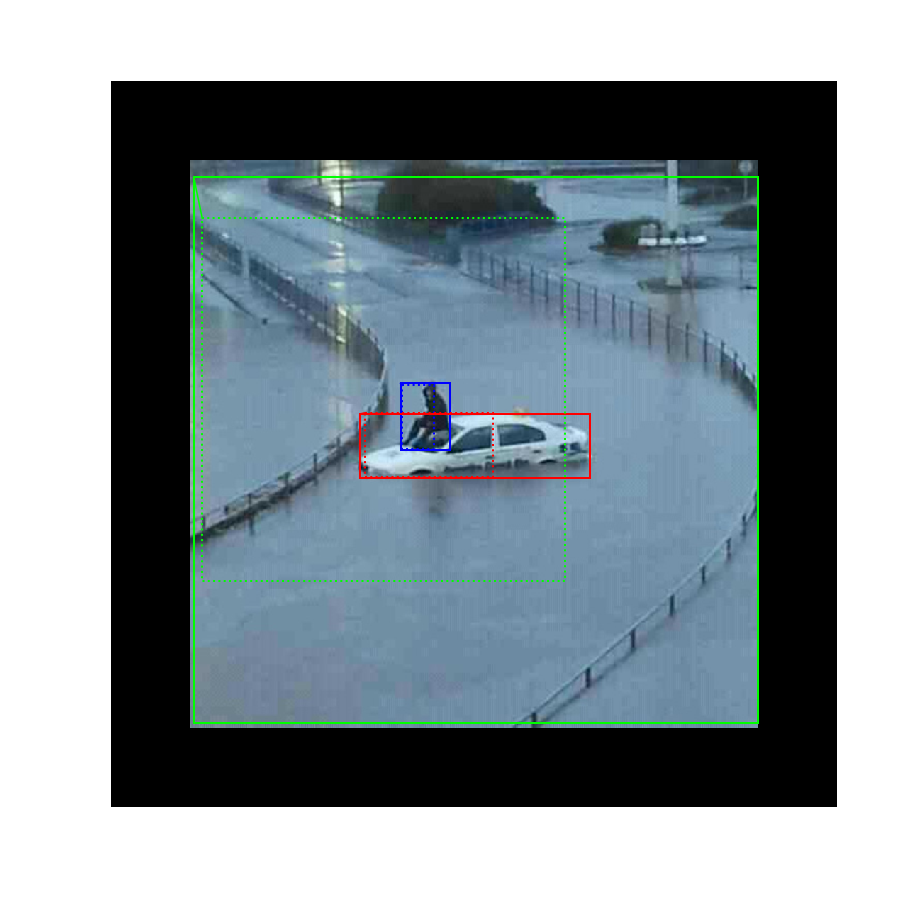

In [29]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [30]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000
pre_nms_anchors          shape: (1, 6000, 4)          min: -362.03867  max: 1322.03870
refined_anchors          shape: (1, 6000, 4)          min: -19648484.00000  max: 19649556.00000
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max: 1024.00000
post_nms_anchor_ix       shape: (126,)                min:    0.00000  max: 3579.00000
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


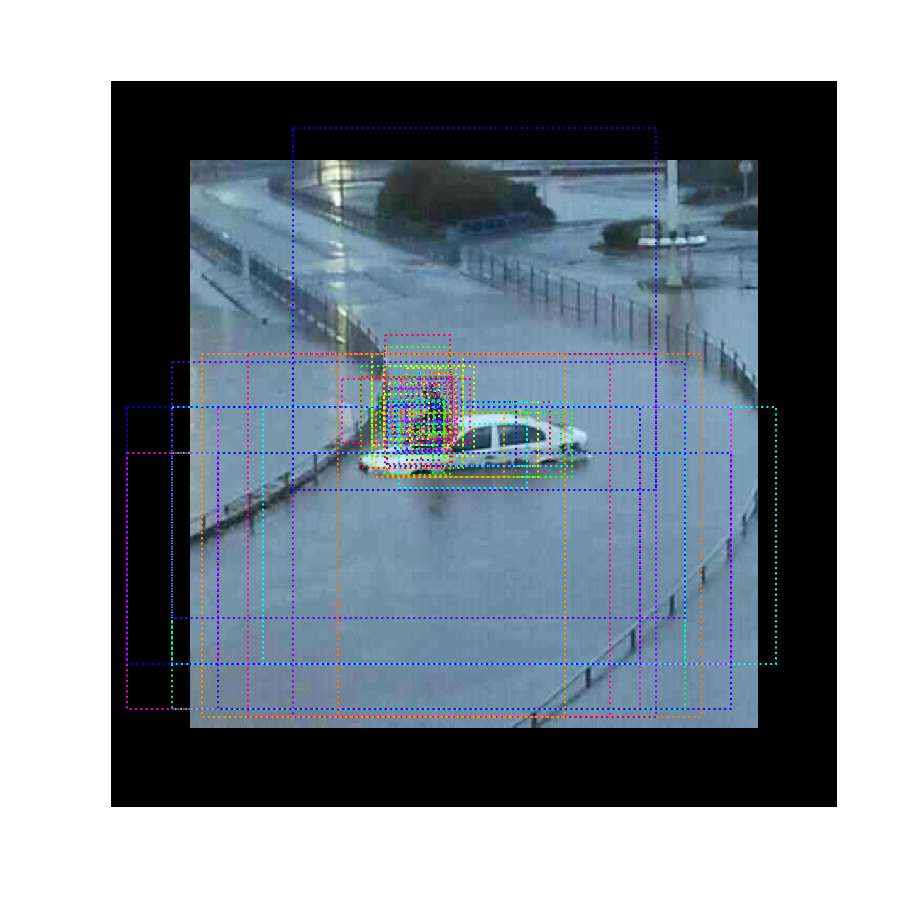

In [31]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

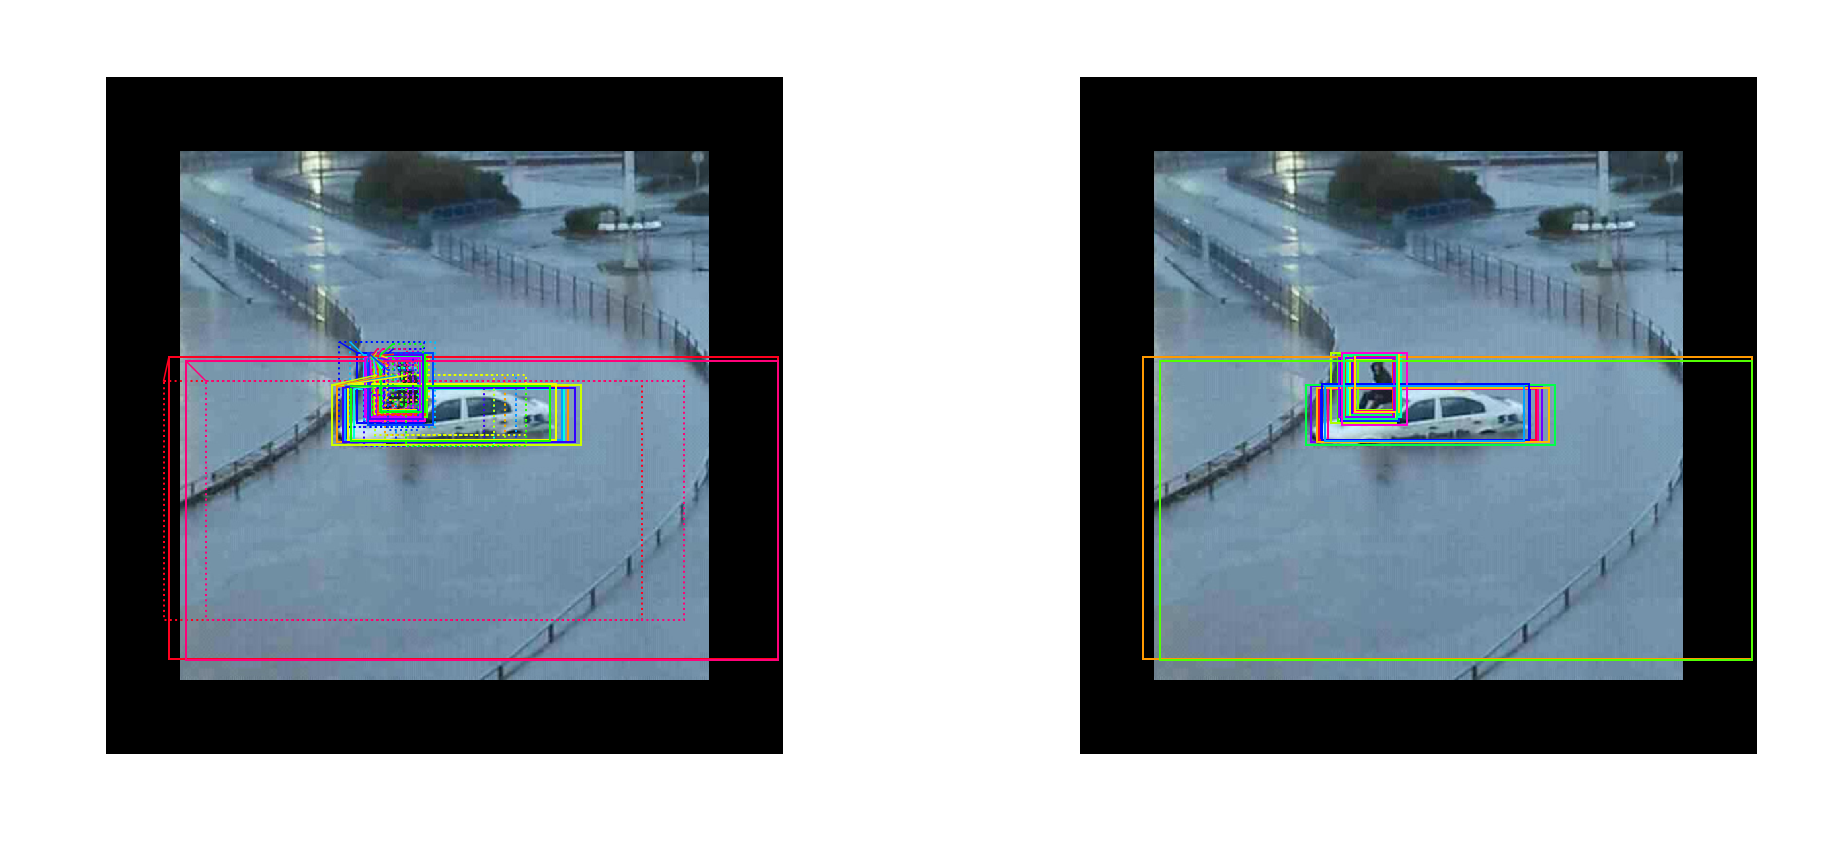

In [32]:
# Show top anchors with refinment. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

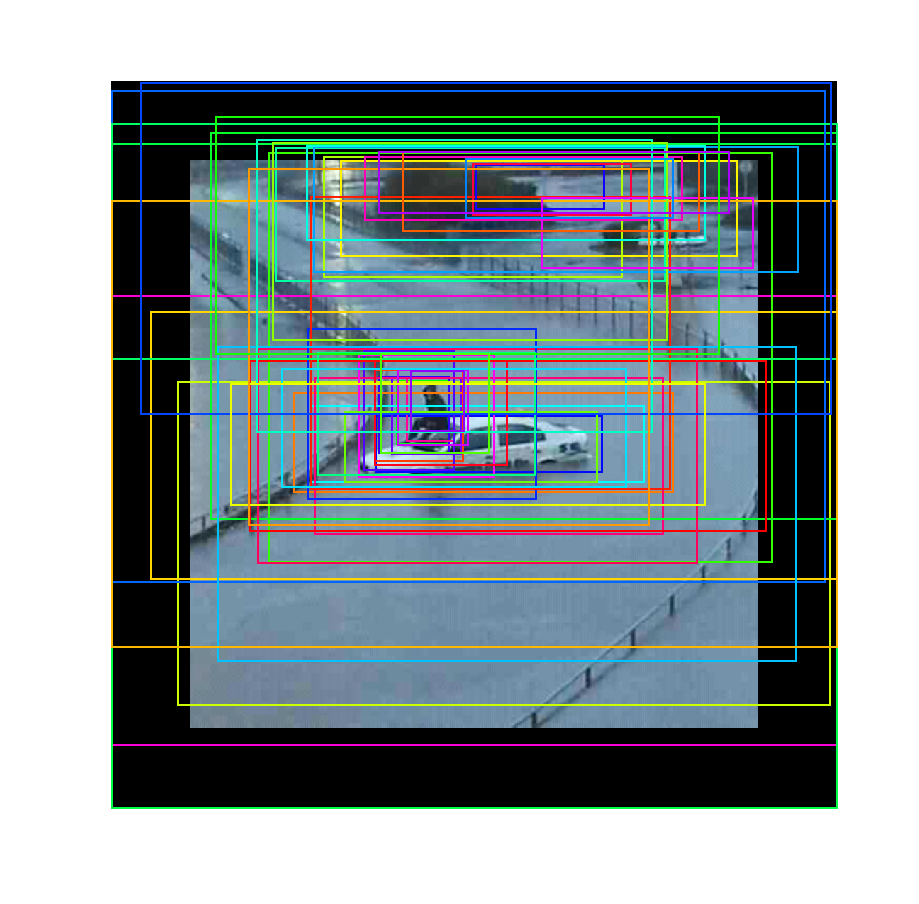

In [33]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

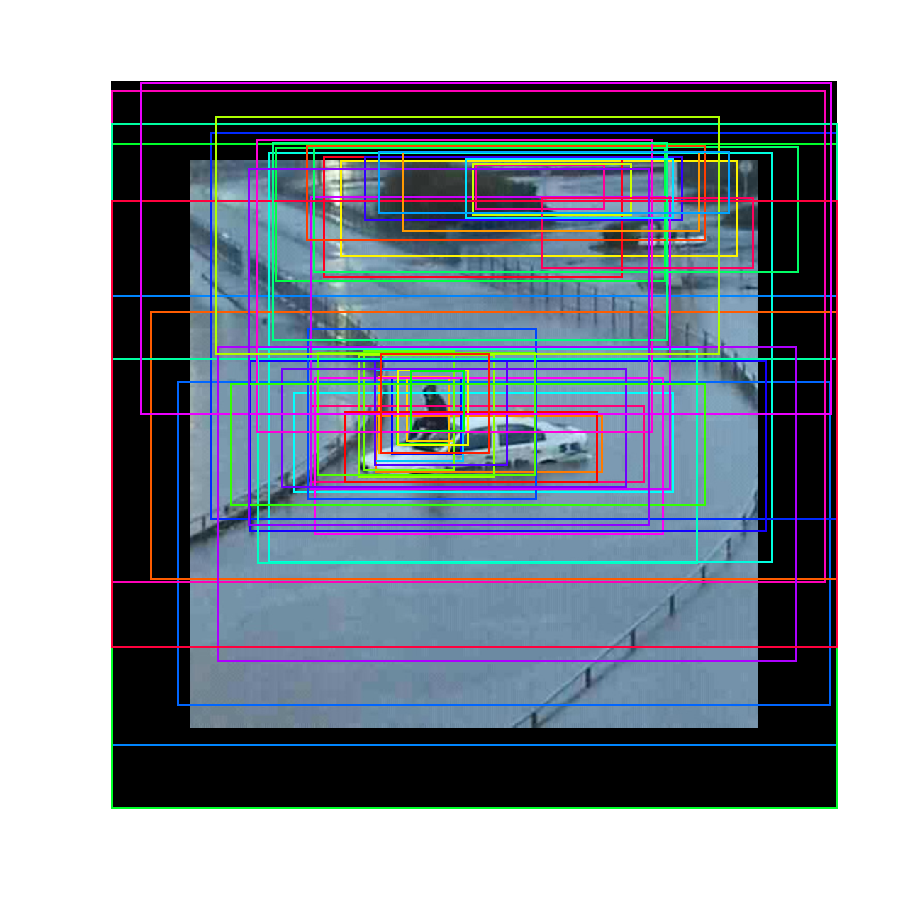

In [34]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [35]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


All Anchors (261888)       Recall: 0.000  Positive anchors: 0
Refined Anchors ( 6000)   Recall: 1.000  Positive anchors: 77
Post NMS Anchors (   50)  Recall: 0.667  Positive anchors: 3


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [36]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 1000, 7)          min:    0.00000  max:    1.00000
deltas                   shape: (1, 1000, 7, 4)       min:   -4.34498  max:    4.40156
masks                    shape: (1, 100, 28, 28, 7)   min:    0.00000  max:    1.00000
detections               shape: (1, 100, 8)           min:    0.00000  max:  891.00000


In [37]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=detections[:, :4],
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

3 detections: ['car' 'person' 'flood']


### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [38]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

126 Valid proposals out of 1000
16 Positive ROIs
[('BG', 984), ('car', 3), ('flood', 8), ('person', 5)]


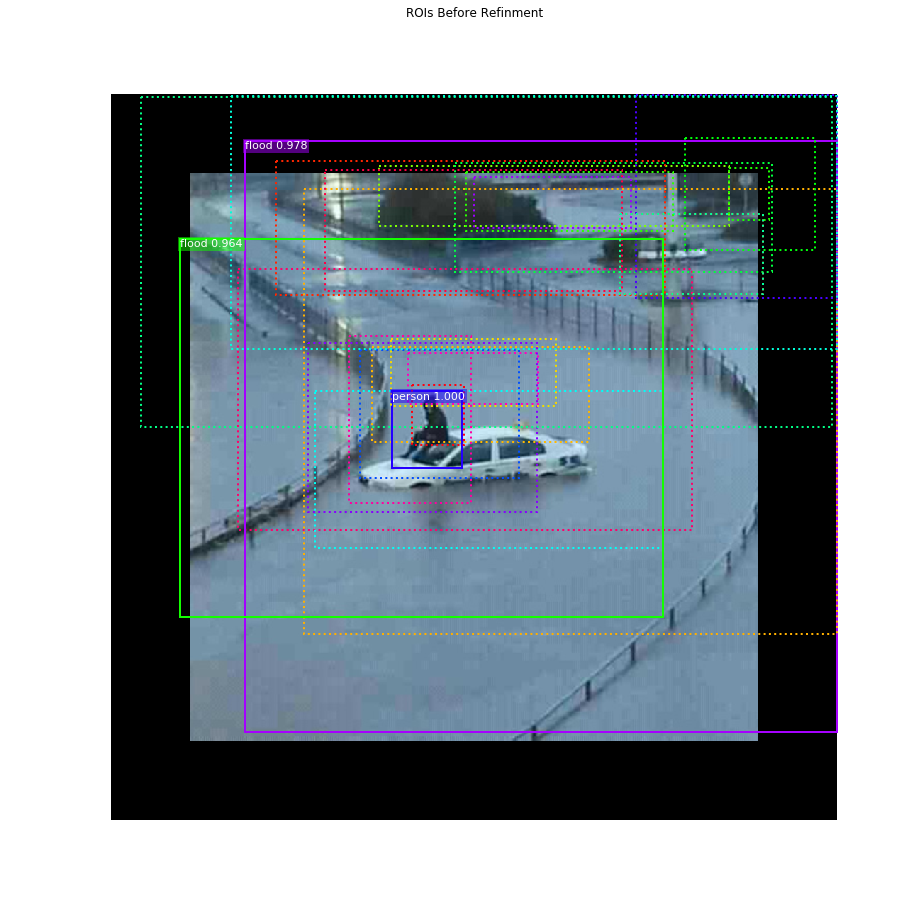

In [39]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinment",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -4.34498  max:    3.85124
refined_proposals        shape: (1000, 4)             min: -136.00000  max: 1498.00000


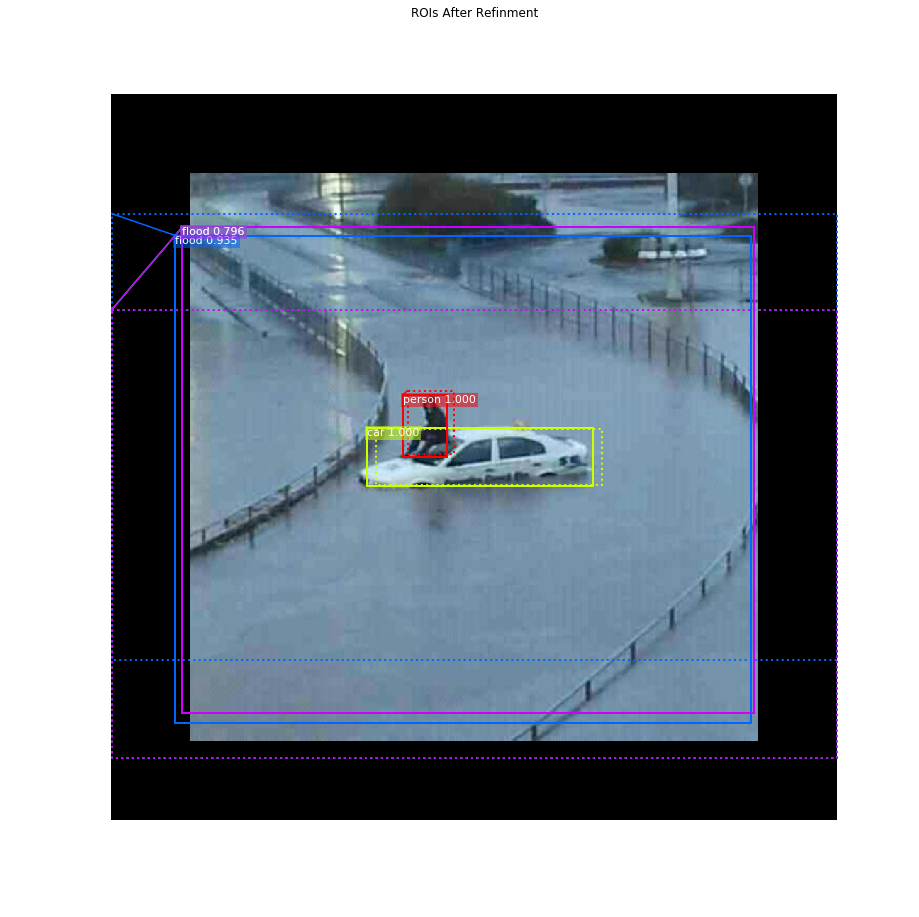

In [40]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinment",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [41]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 16 detections:
[ 0  1  2  3  4  5  6  7 19 21 31 36 37 57 84 91]


In [42]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.7 confidence. Keep 16:
[ 0  1  2  3  4  5  6  7 19 21 31 36 37 57 84 91]


#### Per-Class Non-Max Suppression

In [43]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

person                : [ 0  2  4  5 31] -> [0]
car                   : [ 1  6 21] -> [1]
flood                 : [ 3  7 19 36 37 57 84 91] -> [84]

Kept after per-class NMS: 3
[ 0  1 84]


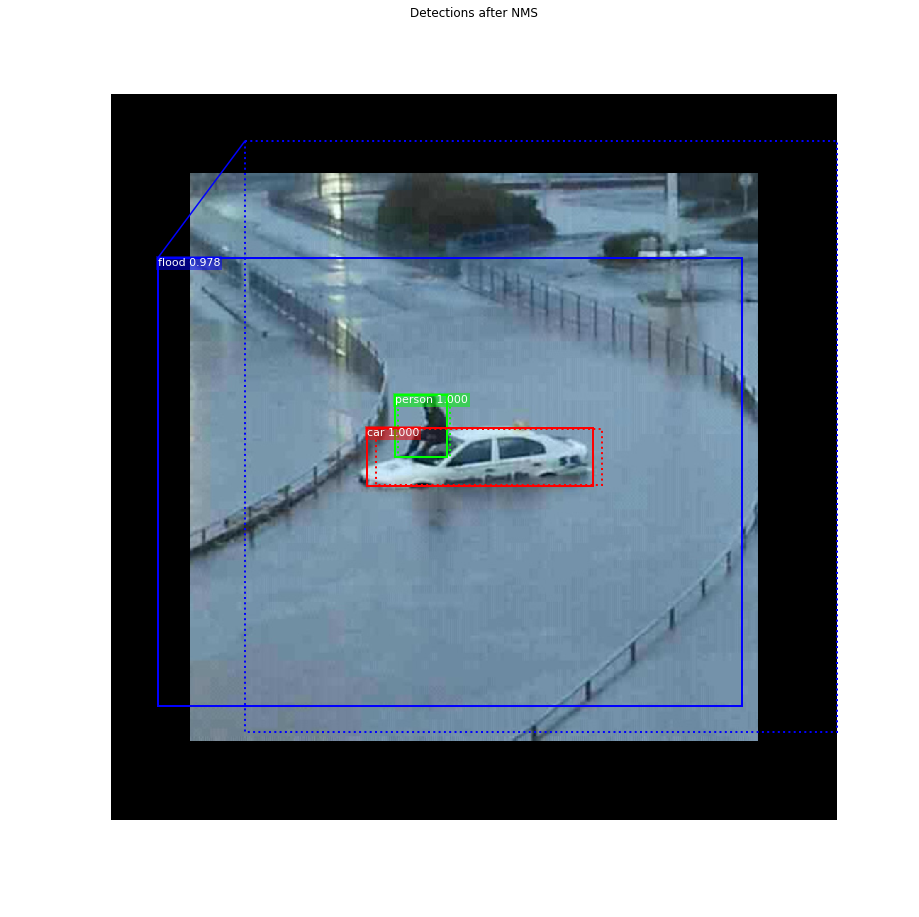

In [44]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

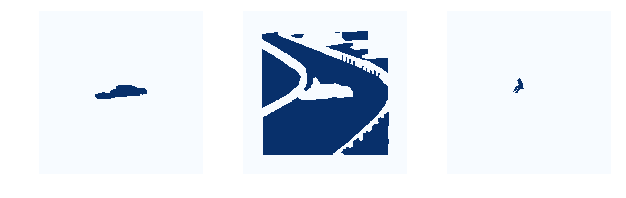

In [45]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [46]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 8)           min:    0.00000  max:  891.00000
masks                    shape: (1, 100, 28, 28, 7)   min:    0.00000  max:    1.00000
3 detections: ['car' 'person' 'flood']


In [47]:
# Masks
det_boxes = mrcnn["detections"][0, :, :4].astype(np.int32)
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (3, 28, 28)           min:    0.00000  max:    1.00000
det_masks                shape: (3, 1024, 1024)       min:    0.00000  max:    1.00000


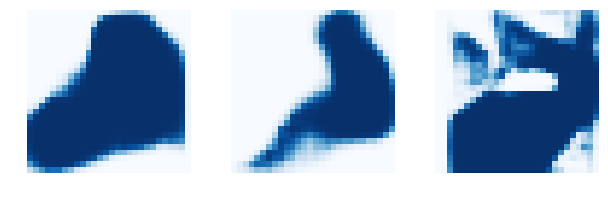

In [48]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

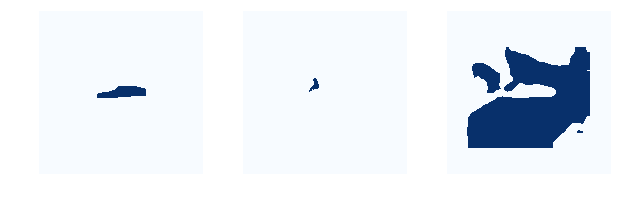

In [49]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [50]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   62.17828
rpn_bbox                 shape: (1, 261888, 4)        min:   -7.74919  max:  310.46982
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


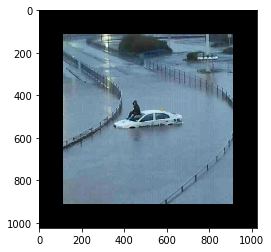

In [51]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

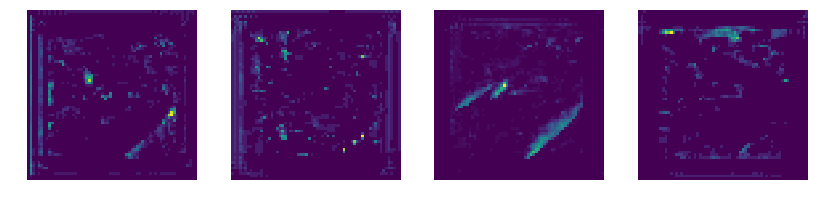

In [52]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

In [53]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

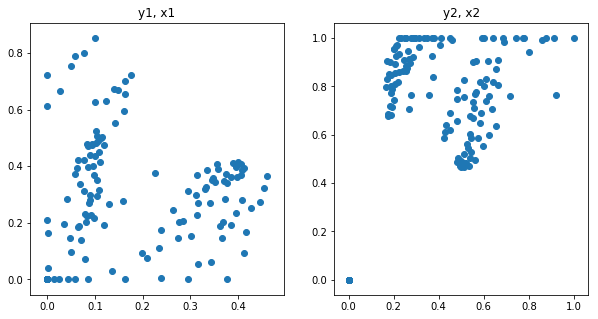

In [54]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()